In [129]:
from torch_geometric.data import Data
import torch
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# Construct the data

In [13]:
acquisition_data = pd.read_csv(r'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\ML-for-Graph-Data-Project\data\labels\OECD_acquisition_data_interpolated.csv')
acquisition_data.drop('Unnamed: 0', axis=1, inplace=True)
acquisition_data

,CO2,COU,Year,Value
0,GBR,BEL,2000,152.0
1,GBR,BEL,2001,274.0
2,GBR,BEL,2002,201.0
3,GBR,BEL,2003,126.0
4,GBR,BEL,2004,128.0
...,...,...,...,...
14737,NZL,LVA,2016,0.0
14738,NZL,LVA,2017,0.0
14739,NZL,LVA,2018,0.0
14740,NZL,LVA,2019,0.0


In [14]:
features_data = pd.read_csv(r'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\ML-for-Graph-Data-Project\data\features\features_interpolated.csv')
features_data.drop('Unnamed: 0', axis=1, inplace=True)
features_data

,Country,Year,Carbon Emissions,Education Expenditure,Foreign Direct Investment (FDI) Inflows,GDP,Health Expenditure,Inflation Rate,Internet Penetration,Life Expectancy,Renewable Energy Production,Unemployment Rate
0,AUS,2000,339446.6,4.887310,1.489298e+10,4.158513e+11,7.599617,4.457435,46.756116,79.234146,8.42,6.28
1,AUS,2001,345645.0,4.889552,1.071713e+10,3.793582e+11,7.682723,4.407135,52.689266,79.634146,8.37,6.74
2,AUS,2002,353371.3,4.891794,1.465632e+10,3.955808e+11,7.878076,2.981575,55.266950,79.936585,8.74,6.37
3,AUS,2003,352581.1,4.894036,8.985246e+09,4.674980e+11,7.882926,2.732596,57.844633,80.239024,7.15,5.93
4,AUS,2004,365808.0,4.896278,4.290767e+10,6.143264e+11,8.090034,2.343255,60.422317,80.490244,6.68,5.39
...,...,...,...,...,...,...,...,...,...,...,...,...
589,USA,2017,4819370.0,5.109220,3.808230e+11,1.947734e+13,16.767937,2.130110,87.274889,78.539024,9.92,4.36
590,USA,2018,4975307.0,4.912330,2.147150e+11,2.053306e+13,16.640944,2.442583,88.498903,78.639024,10.12,3.90
591,USA,2019,4817719.0,4.988710,3.147440e+11,2.138098e+13,16.676474,1.812210,89.430285,78.787805,10.42,3.67
592,USA,2020,4817719.0,6.050000,1.489120e+11,2.106047e+13,18.815826,1.233584,90.620470,76.980488,10.42,8.05


In [56]:
years = range(2000, 2022)

In [222]:
feature_names = ['Carbon Emissions',
                'Education Expenditure',
                'Foreign Direct Investment (FDI) Inflows',
                'GDP',
                'Health Expenditure',
                'Inflation Rate',
                'Internet Penetration',
                'Life Expectancy',
                'Renewable Energy Production',
                'Unemployment Rate']

year_graph = {}
for year in years:
    #  Take one year
    year_data = features_data[features_data['Year'] == year]

    #  Do normalization for features of the fixed year
    normalized_year_data = (year_data[feature_names] - year_data[feature_names].min()) / (year_data[feature_names].max() - year_data[feature_names].min())
    normalized_year_data['Country'] = year_data['Country']

    #  Stack the features of each pair of countries
    crossed_data = pd.merge(normalized_year_data, normalized_year_data, how='cross', suffixes=['_first', '_second'])
    crossed_data = crossed_data[crossed_data['Country_first'] != crossed_data['Country_second']]
    first_country_list = crossed_data['Country_first']
    second_country_list = crossed_data['Country_second']
    crossed_data['countries_pair'] = [(country1, country2) for country1, country2 in zip(first_country_list, second_country_list)]
    crossed_data.drop(['Country_first', 'Country_second'], axis=1, inplace=True)

    #  Calculate euclidean distance between pairs of pairs of countries
    distances = euclidean_distances(crossed_data.drop('countries_pair', axis=1))
    distances = distances / distances.max()  # normalize

    #  Calculate similarity between pairs of pairs of countries
    similarities = 1 - distances
    np.fill_diagonal(similarities, np.nan)

    #  Convert to matrix
    similarities_df = pd.DataFrame(similarities, index=crossed_data['countries_pair'].values, columns=crossed_data['countries_pair'].values)
    #  (or to edgelist)
    # similarities_df = similarities_df.stack().reset_index().rename({'level_0': 'country_pair_1', 'level_1': 'country_pair_2', 0: 'similarity_score'}, axis=1)

    year_graph[year] = similarities_df

In [81]:
27 * 27 - 27

702

In [83]:
702 * 702 - 702

492102

In [66]:
year_graph[2000].shape

(492102, 3)

In [213]:
def brute_force_optimal_threshold(year_graph, similarity=True):
    x = np.linspace(0, 1, 21)
    sparsity_mean = []
    sparsity_std = []
    connected_all = []

    for threshold in tqdm(x, leave=True):
        sparsity = []
        connected = []
        for year in years:
            #  Filter the year and the similarity/dissimilarity threshold
            matrix = year_graph[year]
            if similarity:
                filtered_matrix = matrix[matrix >= threshold]
            else:
                filtered_matrix = matrix[matrix <= threshold]

            #  Calculate sparsity
            number_of_edges = filtered_matrix.notna().sum().sum()
            sparsity.append(number_of_edges / 492102)

            #  Check connectivity
            if number_of_edges == 0:
                connected.append(0)
            else:
                # graph = nx.from_pandas_edgelist(filtered_edgelist, 'country_pair_1', 'country_pair_2', 'similarity_score')
                graph = nx.from_pandas_adjacency(filtered_matrix.replace(np.nan, 0), create_using=nx.DiGraph())
                connected.append(nx.is_weakly_connected(graph))
        
        #  Update global statistics
        sparsity_mean.append(np.mean(sparsity))
        sparsity_std.append(np.std(sparsity))
        connected_all.append(np.prod(connected))
    return x, sparsity_mean, sparsity_std, connected_all


def plot_sprsity_vs_threshold(x, sparsity_mean, sparsity_std, connected_all, similarity=True):
    plt.errorbar(x, sparsity_mean, yerr=sparsity_std, fmt='', ls='none', color='grey')
    plt.scatter(x, sparsity_mean, c=['#1a05' if x else '#ff7f50' for x in connected_all])

    plt.xlabel('Similarity threshold')
    plt.ylabel('Mean sparsity')
    plt.grid(visible=True)
    if similarity:
        plt.title('Similarity graph based on euclidean distance')
        x_opt = x[connected_all.index(0)-1]
        sparsiy_opt = sparsity_mean[connected_all.index(0)-1]
    else:
        plt.title('Dissimilarity graph based on euclidean distance')
        x_opt = x[connected_all.index(1)]
        sparsiy_opt = sparsity_mean[connected_all.index(1)]

    plt.scatter(x_opt, sparsiy_opt, s=70, c='red')
    plt.annotate(f'({x_opt:.2f}, {sparsiy_opt:.2f})', 
                (x_opt, sparsiy_opt),
                xycoords='data',
                xytext=(x_opt - 0.15, sparsiy_opt + 0.05))

### Similarity graph

  0%|          | 0/21 [00:00<?, ?it/s]

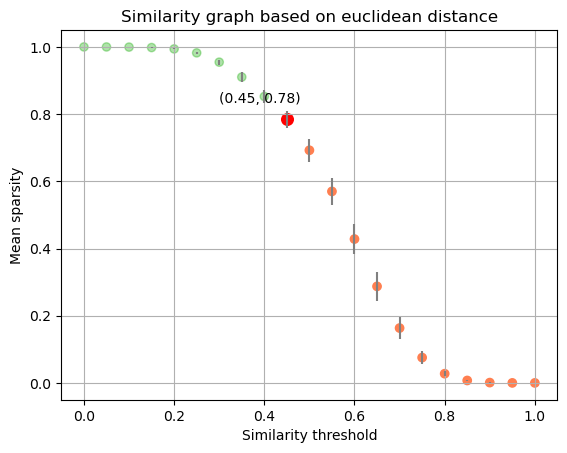

In [214]:
x, sparsity_mean, sparsity_std, connected_all = brute_force_optimal_threshold(year_graph, similarity=True)
plot_sprsity_vs_threshold(x, sparsity_mean, sparsity_std, connected_all)

In [226]:
for year in years:
    matrix = year_graph[year]
    filtered_matrix = matrix[matrix >= 0.45]
    similarities_df = filtered_matrix.stack().reset_index().rename({'level_0': 'country_pair_1', 'level_1': 'country_pair_2', 0: 'similarity_score'}, axis=1)
    similarities_df.to_csv(fr'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\euclidean_similarity\graph_{year}.txt',
                           index=None,
                           header=None)
    print(f'Year {year} is done')

Year 2000 is done
Year 2001 is done
Year 2002 is done
Year 2003 is done
Year 2004 is done
Year 2005 is done
Year 2006 is done
Year 2007 is done
Year 2008 is done
Year 2009 is done
Year 2010 is done
Year 2011 is done
Year 2012 is done
Year 2013 is done
Year 2014 is done
Year 2015 is done
Year 2016 is done
Year 2017 is done
Year 2018 is done
Year 2019 is done
Year 2020 is done
Year 2021 is done


### Dissimilarity graph

  0%|          | 0/21 [00:00<?, ?it/s]

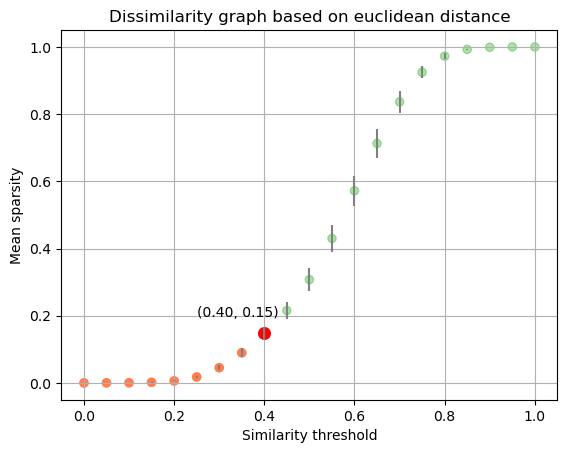

In [227]:
x, sparsity_mean, sparsity_std, connected_all = brute_force_optimal_threshold(year_graph, similarity=False)
plot_sprsity_vs_threshold(x, sparsity_mean, sparsity_std, connected_all,similarity=False)

In [229]:
for year in years:
    matrix = year_graph[year]
    filtered_matrix = matrix[matrix <= 0.4]
    similarities_df = filtered_matrix.stack().reset_index().rename({'level_0': 'country_pair_1', 'level_1': 'country_pair_2', 0: 'similarity_score'}, axis=1)
    similarities_df.to_csv(fr'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\euclidean_dissimilarity\graph_{year}.txt',
                           index=None,
                           header=None)
    print(f'Year {year} is done')

Year 2000 is done
Year 2001 is done
Year 2002 is done
Year 2003 is done
Year 2004 is done
Year 2005 is done
Year 2006 is done
Year 2007 is done
Year 2008 is done
Year 2009 is done
Year 2010 is done
Year 2011 is done
Year 2012 is done
Year 2013 is done
Year 2014 is done
Year 2015 is done
Year 2016 is done
Year 2017 is done
Year 2018 is done
Year 2019 is done
Year 2020 is done
Year 2021 is done


# All imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [ ]:
for year in years:
    edgelist = year_edgelist[year]
    filtered_edgelist = edgelist[edgelist['similarity_score'] < 0.45]
    filtered_edgelist.to_csv(fr'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\euclidean_dissimilarity\graph_{year}.txt')

# Upload all the data

In [ ]:
edgelist, edgelist_tensor = {}, {}
for year in range(2000, 2022):
    #  Read the graph edgelists for each year
    edgelist[year] = pd.read_csv(f'C:\Users\eevmenova\Documents\Courses\Machine Learning for Graph Data\Final project\euclidean_similarity\graph_{year}.txt.csv')
    edgelist_tensor[year] = torch.tensor(edgelist[year].values)
    
    #  Read features
    x = 
# edge_index = 

In [ ]:
data = Data(x=x, edge_index=edge_index, ...)